# Отток клиентов

**Заказчик:** банк А.  
**Цель:** на основе имеющихся данных поведения клиентов Заказчика построить и обучить модель, эффективно предсказывающую возможный отказ клиента от услуг банка А.  

**Задачи:**
1. Ознакомиться с данными, провести процедуру преподготовки. Выявить дисбаланс классов.
2. Построить и обучить модель
3. Добиться максимального показателя целевой метрики F1

## Оглавление

1. [Предобработка данных](#6)
2. [Обучениее модели без учёта дисбаланса классов](#5)  
3. [Подготовка сбалансированной выборки](#4)  
4. [Подбор гиперпараметров](#3)  
5. [Итоговая проверка](#2)
6. [Вывод](#1)

<a id="6"></a>
###  Предобработка данных

In [5]:
data = pd.read_csv("Churn.csv")
display(data)
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные представляют собой историческую информацию о поведении клиентов Банка А, а также расторжении договоров с банком.
- RowNumber — индекс строки в данных  
- CustomerId — уникальный идентификатор клиента  
- Surname — фамилия  
- CreditScore — кредитный рейтинг  
- Geography — страна проживания (категориальный признак)
- Gender — пол  (категориальный признак)
- Age — возраст  
- Tenure — сколько лет человек является клиентом банка  
- Balance — баланс на счёте  
- NumOfProducts — количество продуктов банка, используемых клиентом  
- HasCrCard — наличие кредитной карты  
- IsActiveMember — активность клиента  
- EstimatedSalary — предполагаемая зарплата  
- Exited — факт ухода клиента(1 - ушёл, 0 - остался), **целевой признак**

В столбце Tenure обнаружено около 10% пропущенных значений. 
Выполним проверку на мультиколлинеарность, построим матрицу корреляции.

In [6]:
display(data.corr())

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Выраженной корреляции между признаками не обнаружено (R2 не превышает 0,8).

Заполнение пропусков в столбце Tenure выполним путём заполнения средним по группам.   
Разделим клиентов банка на три группы по возрасту:
- до 30 лет - категория young
- от 30 до 50 лет - категория mature
- от 50 - категория old

In [7]:
def age_categoriser(row):
        if row['Age'] <= 30:
            return 'young' 
        elif 30 < row['Age'] <= 50:
            return 'mature'
        else:
            return 'old'

data['AgeCategory'] = data.apply(age_categoriser, axis = 1)
data.loc[data['Tenure'].isnull(), 'Tenure'] = data.groupby('AgeCategory')['Age'].transform('median')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  AgeCategory      10000 non-null  object 
dtypes: float64(3), int64(8), object(4)
memory usage: 1.1+ MB


Удалим из датафрейма признаки, которые точно не повлияют на предсказания, а именно:
- RowNumber
- CustomerId
- Surname
- AgeCategory



In [8]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname', 'AgeCategory'], axis = 1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**Промежуточный результат:** в сухом остатке имеем "обезличенную" информацию о клиенах банка без пропусков.

Преобразуем категориальные признаки в численные техникой прямого отображения (OHE), во избежание дамми-ловушек передадим методу аргумент `drop_first = True`

In [9]:
data = pd.get_dummies(data, drop_first = True)
display(data)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Чтобы избежать возможного непонимания данных моделью, приведём признаки к одинаковой размерности. Сначала выделим целевой признак и данные для обучения. Разделим выборку на тестовую, валидационную и обучающую. Соотношение 20:20:60

In [10]:
target = data['Exited']
features = data.drop('Exited', axis = 1)

features_train, features_check, target_train, target_check = train_test_split(features, target, 
                                                                              test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_check, target_check,
                                                                           test_size = 0.5, random_state = 12345)

Воспользуемся структурой StandardScaler для масштабирования признаков. Посмотрим на результат.

In [11]:
numeric = ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Age']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,-0.006183,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,-0.006183,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.495636,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,-0.201964,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.593526,1.140475,1,0,0,1.524268,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.397745,-1.233163,2,0,1,-1.278361,0,0,1
4094,-1.447531,-0.942612,0.189597,-1.233163,2,0,1,-1.281307,0,0,1
3492,0.027113,0.575842,2.930529,-0.310229,1,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.397745,-1.233163,2,0,1,-1.128539,0,0,0


In [12]:
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-0.593526,-1.233163,2,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.495636,-1.233163,1,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-0.789307,0.438711,1,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,0.189597,1.239884,1,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,0.189597,-1.233163,2,1,0,1.358533,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6480,0.276349,-1.417129,-0.201964,0.617449,2,0,1,0.628182,0,0,0
8194,-0.211738,0.291132,-0.397745,0.797229,1,1,0,0.026002,0,0,1
1279,-1.364452,0.006422,-0.201964,-1.233163,2,0,1,-1.249087,0,0,0
6532,1.075979,2.663716,-0.397745,-1.233163,3,1,1,-0.111107,0,0,1


In [13]:
features_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-0.593526,-1.233163,2,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,0.091707,-1.233163,1,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,-0.299855,0.722307,1,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,0.189597,-1.233163,2,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,0.189597,0.615625,1,0,1,-1.070919,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9335,0.878668,1.050359,-0.397745,0.820368,2,1,0,-1.650024,1,0,1
7999,1.802916,-1.227322,-0.299855,1.063628,1,0,0,-0.679113,0,0,1
6139,-0.004041,-0.183385,-0.397745,-1.233163,2,1,0,0.760240,0,0,0
9473,-0.460973,0.575842,-0.397745,-1.233163,2,0,0,-1.087632,0,1,1


<div style="border:solid green 2px; padding: 20px">
 
    ВЫВОД:
Данные были подготовлены для анализа: заполнены пропущенные значение, категориальные признаки замещены техникой ОНЕ, числовые признаки подвергнуты масштабированию.

<a id="5"></a>
### Обучение модели без учета дисбаланса классов.

Задача этого исследования - задача бинарной классификации. Простейшие модели для решения задач бинарной классификации: модель дерева или случайного леса.

Обучим три модели без учета баланса классов. В качестве показателя качества модели используем F1. 

<div class="alert alert-info">
В требованиях Заказчика указано:  
    
    "сохранять текущих клиентов дешевле, чем привлекать новых".   

Определяемся с Accuracy, Recall и Precision, подберём наиболее подходящие к заданию метрики из этих трёх. 
    
По сути эта фраза призывает нас к минимизации FN-результатов, то есть ситуация
    
    клиент ушел, а мы предсказали, что он останется  
    
страшнее, чем  
    
    предсказали, что клиент уйдёт, а он остался.  
    
Наряду с универсальной  Accuracy в этом исследовании пригодится метрика, в смысл которой вписана минимизация FN. Такой смысл заложен в формуле расчёта Recall (полноты).

In [14]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Полнота:', recall_score(target_valid, predicted_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))

Полнота: 0.5
F1-мера: 0.49880668257756566
Accuracy 0.79


In [15]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Полнота:', recall_score(target_valid, predicted_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))

Полнота: 0.46172248803827753
F1-мера: 0.5693215339233039
Accuracy 0.854


<div style="border:solid green 2px; padding: 20px">
ВЫВОД:
Без учёта баланса классов точность, полнота и F1 нашей модели невысоки.

<a id="4"></a>
### Подготовка сбалансированной выборки

Сначала посмотрим, какую долю от всех значений заанимают значения целевого признака. 

In [16]:
data['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

80 на 20 — ушедших клиентов в датасете в четыре раза меньше, чем оставшихся.
Налицо явная несбалансированность классов. Попробуем устранить эту проблему, использовав последовательно upsampling и downsampling.

#### Upsampling

In [17]:
features_train_zeros = features_train[target == 0]
features_train_ones = features_train[target == 1]
target_train_zeros = target_train[target == 0]
target_train_ones = target_train[target == 1]
features_train_upsampled = pd.concat([features_train_zeros] + [features_train_ones] * 4)
target_train_upsampled = pd.concat([target_train_zeros] + [target_train_ones] * 4)
features_train, target_train = shuffle(
        features_train_upsampled, target_train_upsampled, random_state=12345)

In [18]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3637,2.000228,1.240166,-0.789307,-1.233163,1,1,0,-1.173721,0,1,0
3248,-1.416376,-0.373192,-0.299855,0.838089,1,1,0,0.485993,0,0,1
7516,-0.087120,0.101325,-0.006183,0.267035,1,1,0,-0.443622,0,0,1
7542,-1.509840,-0.468095,-0.397745,-1.233163,2,1,1,-0.672132,0,1,0
3490,-2.070620,-0.942612,1.853735,-1.233163,1,0,0,1.712492,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3636,0.110192,-0.752805,-0.397745,0.432005,2,0,1,-1.091412,0,1,1
9507,1.615990,0.196229,-0.789307,-1.233163,1,1,1,-0.339599,0,0,1
2870,0.567123,1.524876,-0.691416,-1.233163,2,0,1,-0.780877,0,0,0
5585,-2.288701,-0.088482,-0.593526,0.949276,2,1,1,-0.478714,1,0,1


В сбалансированной выборке посмотрим на соотношение долей классов

In [19]:
target_train.value_counts(normalize = True)

0    0.501043
1    0.498957
Name: Exited, dtype: float64

Почти 50 на 50. Такое соотношение классов допустимо. Сбалансированные выборки дадут следующие результаты метрик:

In [20]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))

Полнота: 0.48564593301435405
F1: 0.49331713244228437
Accuracy 0.7915


In [21]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))

Полнота: 0.5406698564593302
F1: 0.601063829787234
Accuracy 0.85


<div style="border:solid green 2px; padding: 20px">
Модель случайного леса ожидаемо даёт лучшие результаты. Далее будем работать только с ней.

#### Downsampling

In [22]:
features_downsampled = pd.concat([features_train_zeros.sample(frac=0.25, random_state=12345)] + [features_train_ones])
target_downsampled = pd.concat([target_train_zeros.sample(frac=0.25, random_state=12345)] + [target_train_ones])
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

target_downsampled.value_counts(normalize = True)

0    0.501043
1    0.498957
Name: Exited, dtype: float64

In [23]:
model1 = RandomForestClassifier(random_state=12345)
model1.fit(features_downsampled, target_downsampled)
predicted_valid = model1.predict(features_valid)
print("Полнота:", recall_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))

Полнота: 0.7392344497607656
F1: 0.5841209829867675
Accuracy 0.78


<a id="3"></a>
### Подбор гиперпараметров

Подбор гиперпараметров модели, обученной на уменьшенных данных.

Сориентируемся, как ведут себя результаты на разных интервалах значений гиперпараметров. Более пристально рассмотрим необходимые значения вложенным циклом.

In [24]:
best_model = None
best_result = 0 
for depth in range(1, 10, 1):
    for n in range(1, 30, 1):
        model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators = n)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_n = n
print("Лучшая F1 модели:", best_result, ', при максимальной глубине дерева:', best_depth, ", и максимальном количестве деревьев:", best_n)       

Лучшая F1 модели: 0.6291666666666668 , при максимальной глубине дерева: 8 , и максимальном количестве деревьев: 25


Итак, подобранные гиперпараметры:  
    **Глубина дерева: 8**  
    **Максимальное количество деревьев: 25**  

Обучим и проверим эффективность модели с подобранными гиперпараметрами на тестовой выборке.

In [25]:
model = RandomForestClassifier(n_estimators=25, max_depth=8, random_state=12345)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("Полнота:", recall_score(target_test, predicted_test))
print("Accuracy:",accuracy_score(target_test, predicted_test))
print("F1:", f1_score(target_test, predicted_test))

Полнота: 0.6855791962174941
Accuracy: 0.8055
F1: 0.5985552115583075


<a id="2"></a>
### Итоговая проверка

Выполним проверку модели, обучив её на 75% известных данных.

In [26]:
features_train_final = pd.concat([features_train, features_valid], ignore_index = True)
target_train_final = pd.concat([target_train, target_valid], ignore_index = True)

model = RandomForestClassifier(n_estimators=25, max_depth=8, random_state=12345, class_weight = 'balanced')
model.fit(features_train_final, target_train_final)
predicted_test = model.predict(features_test)
print("Полнота:", recall_score(target_test, predicted_test))
print("Accuracy",accuracy_score(target_test, predicted_test))
print("F1:", f1_score(target_test, predicted_test))

Полнота: 0.6832151300236406
Accuracy 0.804
F1: 0.5958762886597939


#### Визуализация ROC-кривой

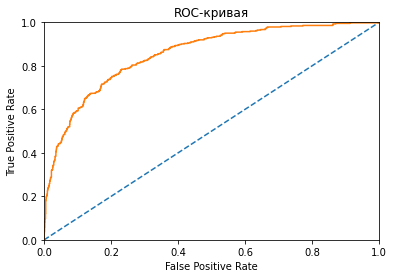

In [28]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [29]:
print("ROC-AUC", roc_auc_score(target_test, probabilities_one_test))

ROC-AUC 0.8547793263385756


<a id="1"></a>
### Вывод

Проанализировав модель, мы подобрали такие гиперпараметры, которые сделали нашу модель максимально эффективной, то есть сделали F1-меру максимально высокой, при этом полнота: 0.71, точность: 0.83. 
Обученная в результате работы модель будет полезна при необходимости вычленить возможных нелояльных клиентов банка, что позволит маркетологам удержать их путём своевременного предложения дополнительных продуктов и/или услуг, а значит предотвратит потерю клиентов Банком А.